# Imports and utility functions

In [653]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multianndata as md
import tpae.data.samples as tds
import tpae.data.patchcollection as tdp
import tpae.association as ta
import tpae.training as tt
import tpae.vis as tv
import gc, os, cna, torch
import scanpy as sc
torch.set_default_device('mps') # for running on macbook's GPU

patchsize = 40; patchstride = 10

In [786]:
def do_cna(d):
    cna.tl.nam(d, force_recompute=True)
    np.random.seed(0)
    res = cna.tl.association(d, d.samplem.fstar.values, donorids=d.samplem.donor.values, Nnull=100000)
    print(f'Ncases={d.samplem.fstar.sum()}: P = {res.p}, used {res.k} PCs')
    d.obs['ncorr'] = res.ncorrs
    if res.fdrs.fdr.min() <= 0.1:
        print(f'{res.fdrs[res.fdrs.fdr < 0.1].iloc[0].num_detected} at FDR 10%')
        d.obs['ncorr_thresh'] = res.ncorrs * (np.abs(res.ncorrs) > res.fdrs[res.fdrs.fdr < 0.1].iloc[0].threshold)
    else:
        d.obs['ncorr_thresh'] = 0
    d.samplem['yhat'] = res.yresid_hat

# Load dataset and make patches

In [170]:
# read in samples
def fname_parser(fname):
    fname = fname.split('/')[-1].split('.nc')[0]
    return {
        'donor': fname.split('_')[0].replace('Repeat',''),
        'sid': fname
    }
repname = 'pca_k=5_harmony'
samples = tds.read_samples(f'../RA/BHAM-data/10u/{repname}/*.nc', fname_parser)

100%|███████████████████████████████████████████████████████████████| 27/27 [00:06<00:00,  4.33it/s]


In [679]:
# choose which patches to train on
P = tdp.PatchCollection(
    tds.choose_patches(samples, patchsize, patchstride, max_frac_empty=0.8),
                        samples, standardize=True)
sid_nums = {sid:sid_num for sid, sid_num in P.meta[['sid','sid_num']].drop_duplicates().values}
print(len(P), 'patches')

# choose which patches to do case/ctrl analysis on
Pdense = tdp.PatchCollection(
    tds.choose_patches(samples, patchsize, patchstride, max_frac_empty=0.2),
                        samples, sid_nums=sid_nums, standardize=True)
print(len(Pdense), 'dense patches')

100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  6.99it/s]


in pytorch mode
means: [-0.01986611  0.01846968  0.16044885  0.01280873  0.03556303]
stds: [1.002968  1.0236002 0.9741667 0.6845497 0.5384412]
data augmentation is off
10345 dense patches


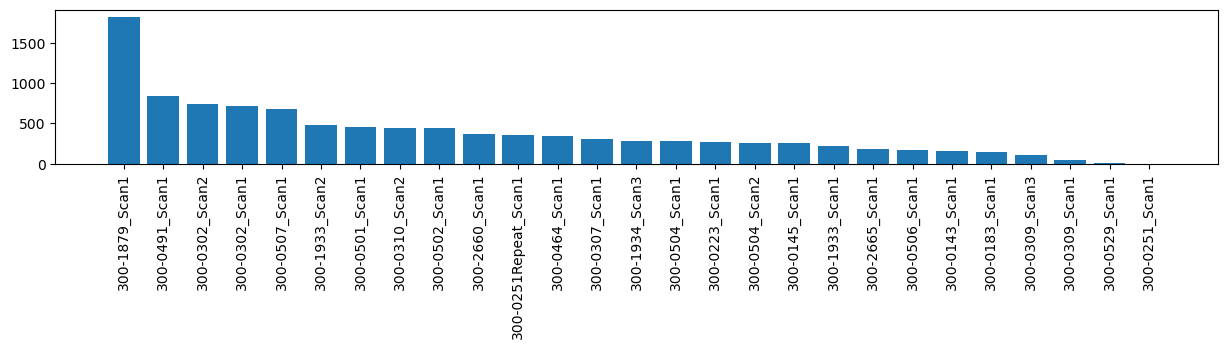

27it [00:05,  5.27it/s]
/Users/yakir/Dropbox/py/tpae/data/samples.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


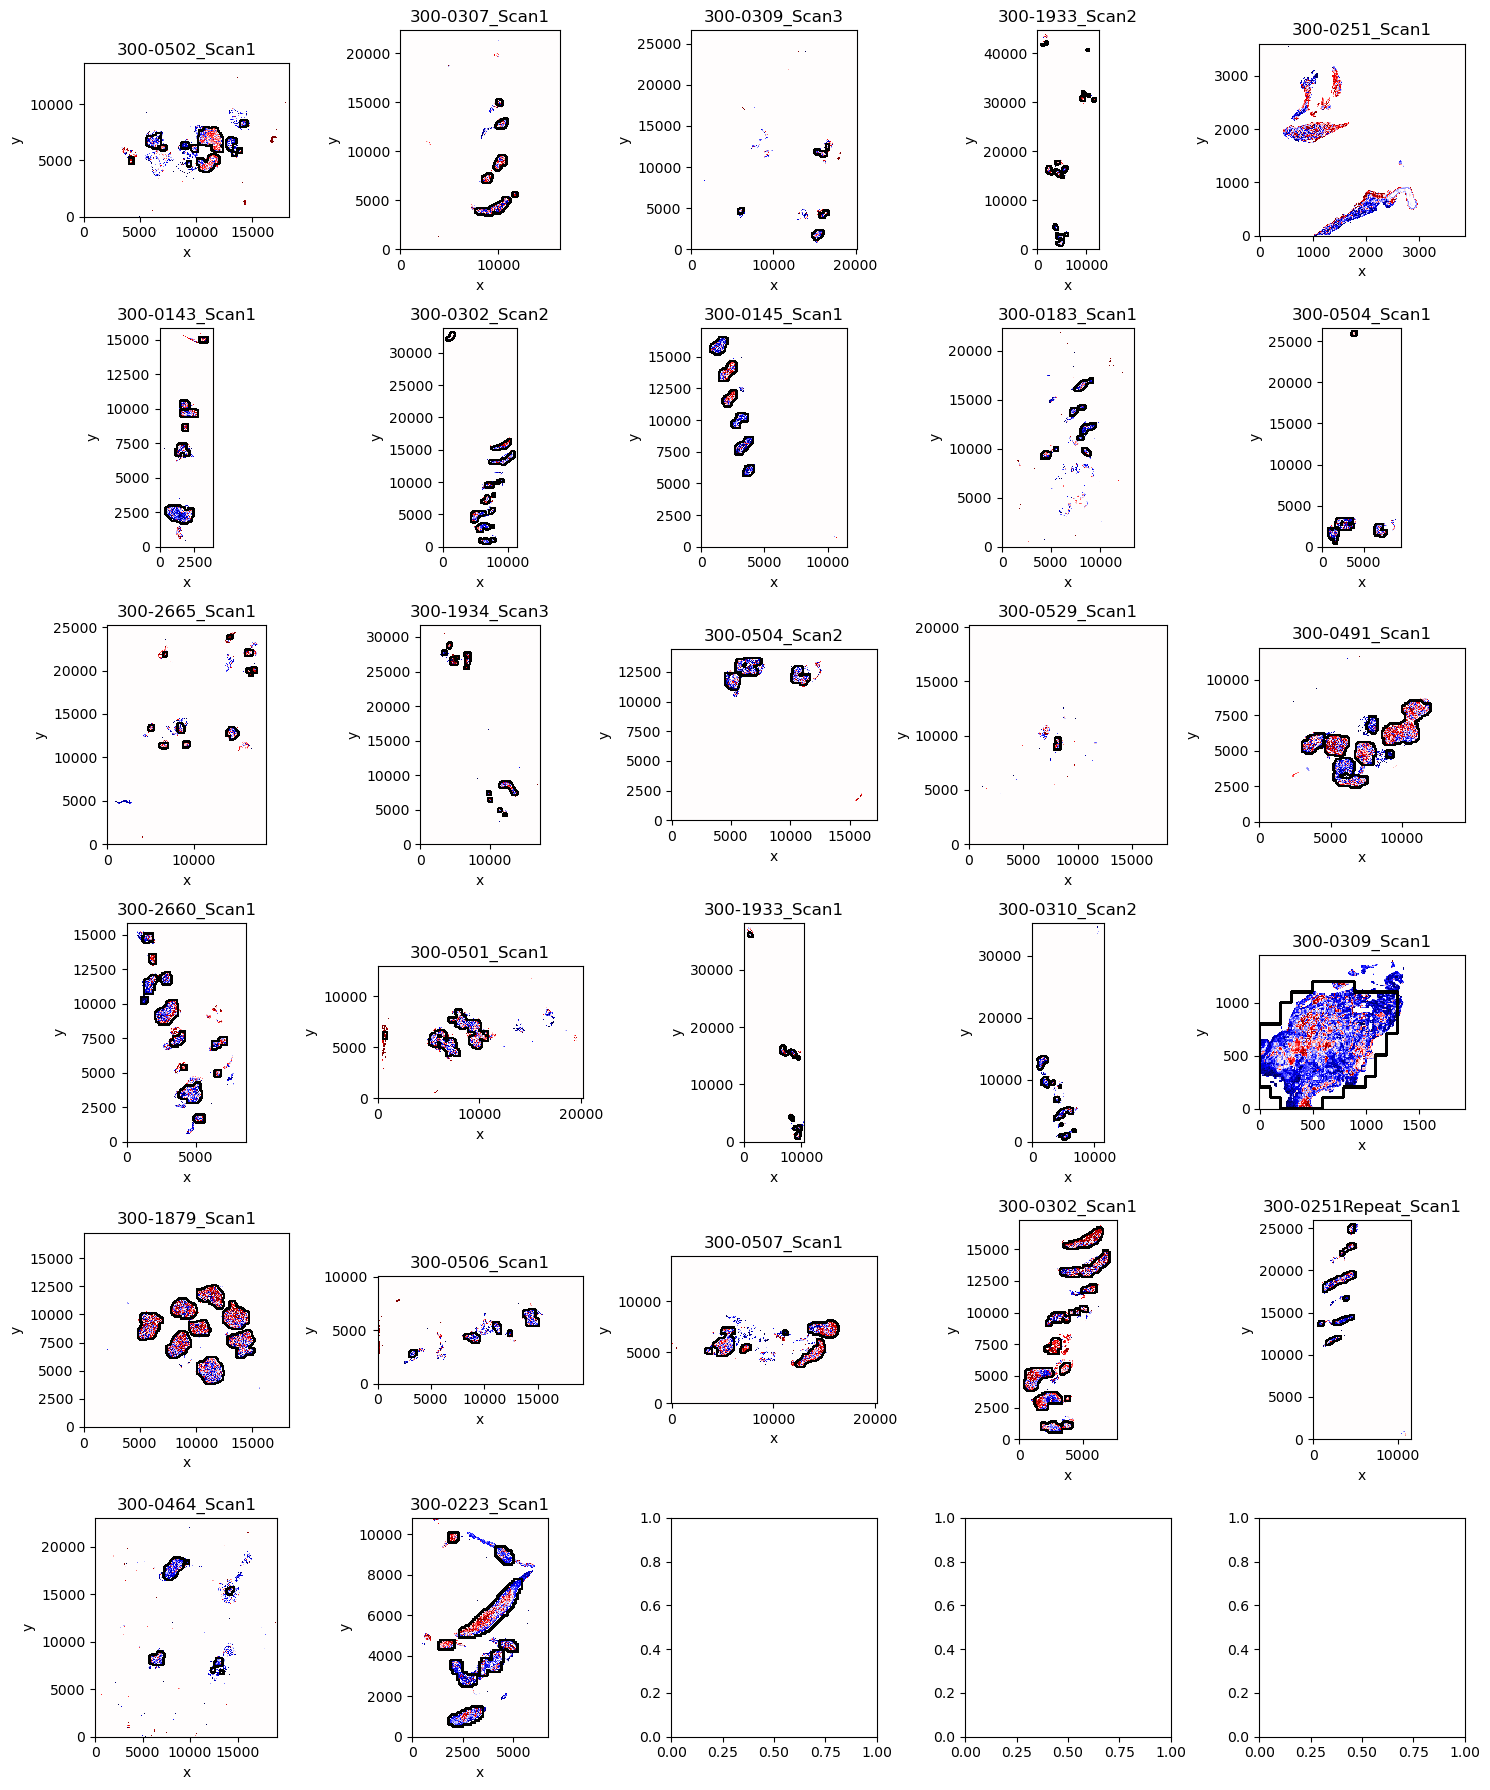

In [172]:
# visualize resulting patches
tds.plot_npatches_per_sample(samples, Pdense.meta)
tds.plot_samples_with_patches(samples.values(), 'hPC1', Pdense.meta, ncols=5, vmin=-2, vmax=2, cmap='seismic')

In [173]:
# read in sample metadata
fullmeta = pd.read_csv('../RA/BHAM-data/ihc-metadata.csv').set_index('subject_id')[['CTAP']]
fullmeta.index = fullmeta.index.str.replace('V0', '')
inourdata = P.meta[['sid','donor']].drop_duplicates()
samplemeta = pd.merge(inourdata, fullmeta, left_on='donor', right_index=True, how='left').set_index('sid', drop=True)
samplemeta = pd.merge(samplemeta, pd.get_dummies(samplemeta.CTAP.str.replace(' + ', ''), prefix='', prefix_sep=''),
        left_index=True, right_index=True)
samplemeta['fstar'] = samplemeta.F | samplemeta.TF | samplemeta.EFM

# Train VAE

In [733]:
from tpae.models.resnet_vae import ResnetVAE
tt.seed(0)
model = ResnetVAE(len(P.meta.sid.unique()), network='light', mode='advanced', ncolors=P.nchannels, nlatent=50)
kl_weight = 1e-5
name = 'default'
os.makedirs(f'./models', exist_ok=True)

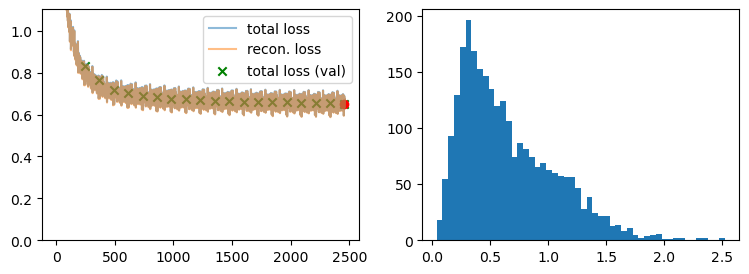

epoch 20. best validation loss = 0.6523467302322388
	total time: 966.2387201786041


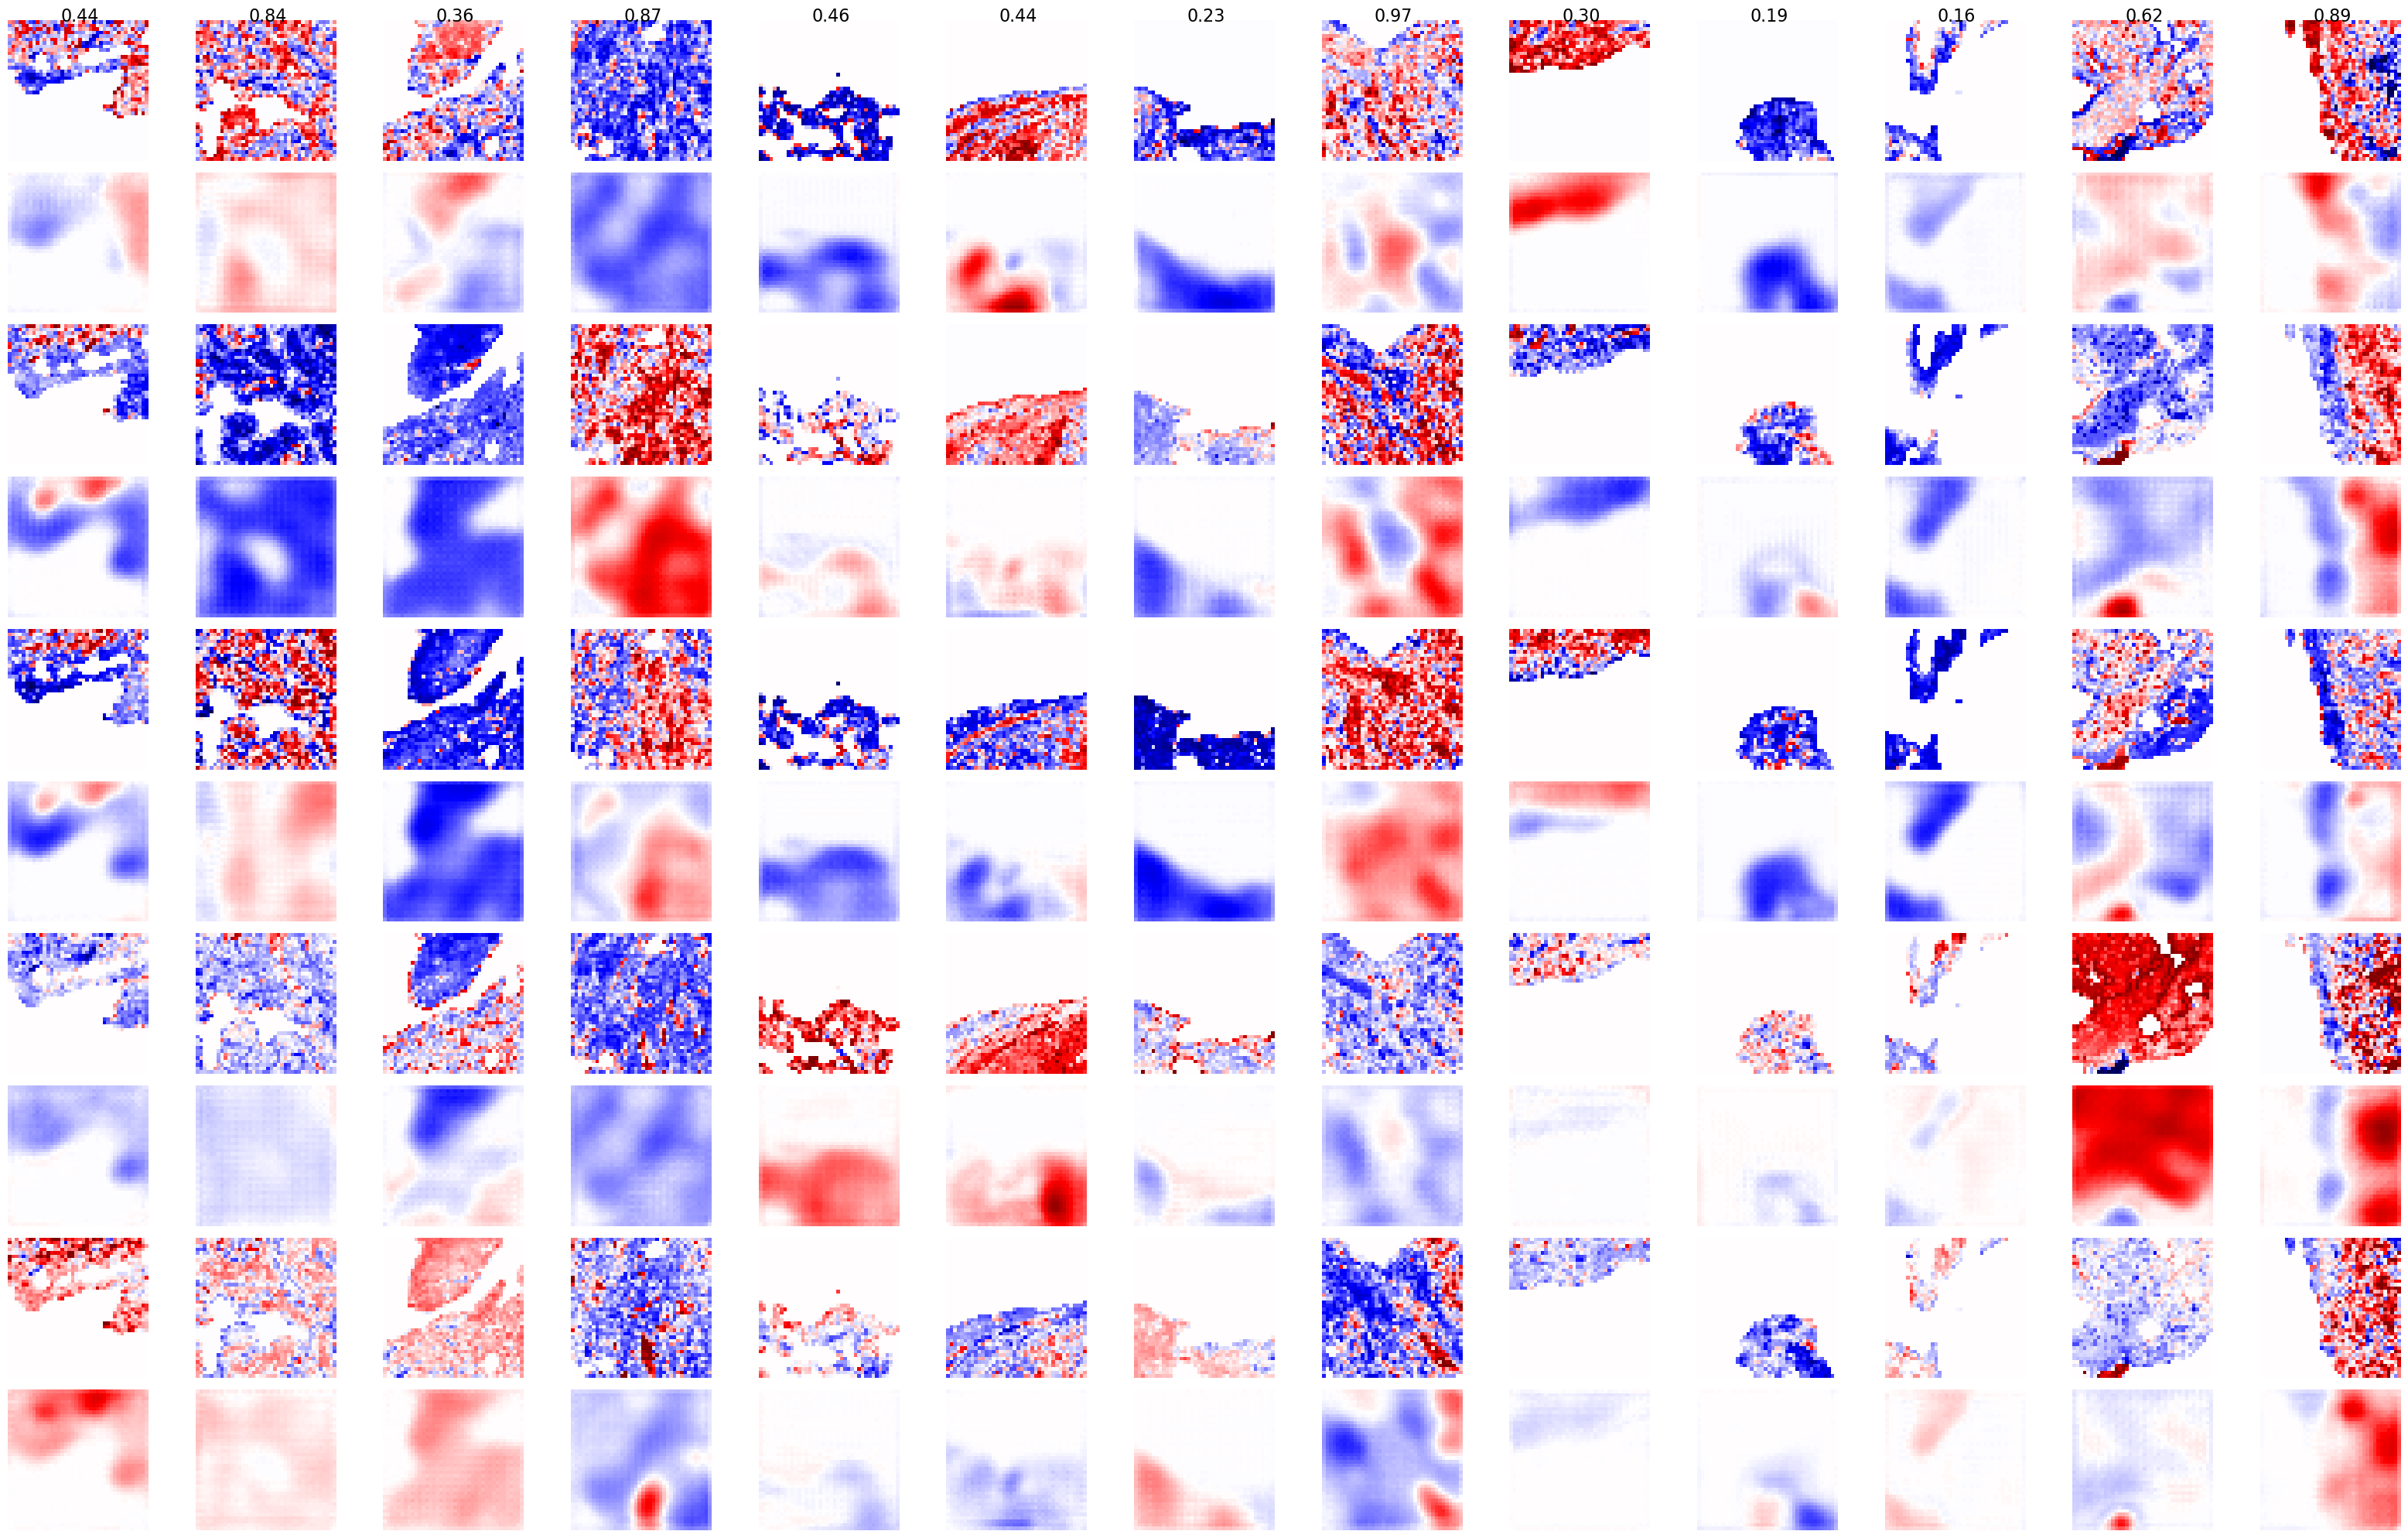

In [734]:
train_dataset, val_dataset = tt.train_test_split(P)
tv.plot_patches_separatechannels(val_dataset[:16][0].permute(0,2,3,1).cpu().numpy())

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
model, losslogs = tt.full_training(model, train_dataset, val_dataset, optimizer, scheduler, batch_size=256, n_epochs=20,
                                kl_weight=kl_weight,
                                per_epoch_logging=tt.detailed_per_epoch_logging,
                                per_epoch_kwargs={'Pmin':P.vmin, 'Pmax':P.vmax})
torch.save(model.state_dict(), f'_results/RA/{name}-vae.pt')

# Create patch representations

## VAE representation

in pytorch mode
data augmentation is off


100%|███████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.91it/s]


running UMAP
built MultiAnnData object with sid as the unit of analysis


/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


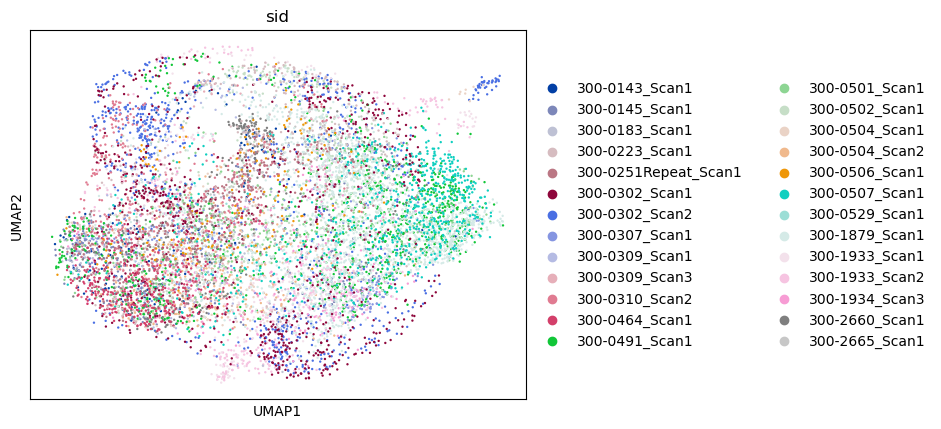

In [736]:
# load model
from tpae.models.resnet_vae import ResnetVAE
model = ResnetVAE(len(P.meta.sid.unique()), network='light', mode='advanced', ncolors=P.nchannels, nlatent=50)
name = 'RAnew_latent50'
model.load_state_dict(torch.load(f'_results/RA/{name}-vae.pt'))

# apply model and build umap
Ddense = ta.anndata(Pdense.meta,
                    ta.apply(model, Pdense, embedding=model.embedding),
                    samplemeta[samplemeta.index.isin(Pdense.meta.sid.unique())],
                    sampleid='sid')
sc.pl.umap(Ddense, color='sid')

# fine clustering and save
# for resolution in [2,3,4,5,10]:
#     print(resolution, end='|')
#     sc.tl.leiden(Ddense, resolution=resolution, key_added=f'leiden{resolution}')
Ddense.write(f'_results/RA/{name}-vae.h5ad')

# Patchwide avg representation

data augmentation is off
in numpy mode


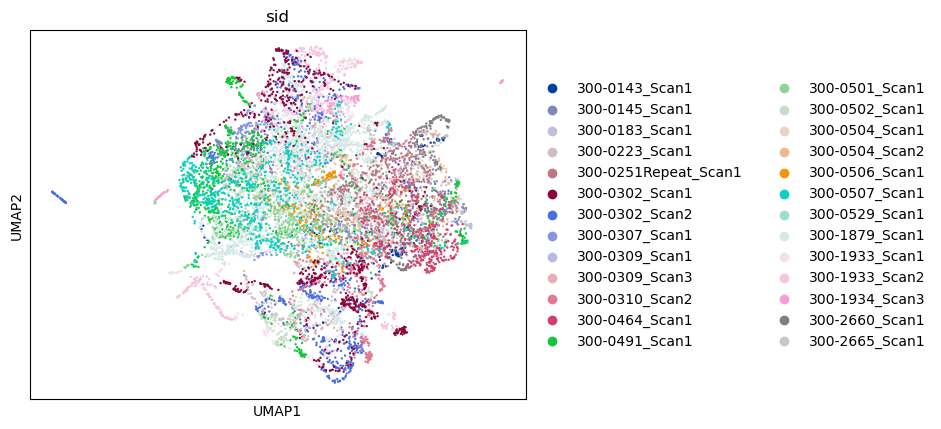

In [205]:
Pdense.numpy_mode()
Ddense_avg = md.MultiAnnData(
    X=Pdense[:][0].mean(axis=(1,2)),
    obs=Ddense.obs)
Ddense_avg.samplem = Ddense.samplem
Ddense_avg.sampleid = 'id'
sc.pp.neighbors(Ddense_avg, use_rep='X')
sc.tl.umap(Ddense_avg)
Ddense_avg.write(f'_results/RA/patchwideavgs.h5ad')
sc.pl.umap(Ddense_avg, color='sid')

# Case-control analysis

## patchwide averages -> cluster -> T-test

In [597]:
from scipy.stats import ttest_ind
d = Ddense_avg
sc.tl.leiden(d, resolution=1)
ct = pd.crosstab(d.obs.sid, d.obs.leiden)
ct = ct.div(ct.sum(axis=1), axis=0)
ct['donor'] = d.samplem.donor
ct['fstar'] = d.samplem.fstar
ct = ct.groupby('donor').aggregate('mean')

In [598]:
ps = []
sts = []
for c in d.obs.leiden.unique():
    ttest = ttest_ind(ct[ct.fstar==1][c], ct[ct.fstar==0][c])
    ps.append(ttest.pvalue)
    sts.append(ct[ct.fstar==1][c].mean() - ct[ct.fstar==0][c].mean())
pd.DataFrame(data={'p':ps, 'stat':sts}, index=pd.Series(d.obs.leiden.unique(), name='cluster')
            ).to_csv('_results/RA/patchwideavgs_ttest.csv')

## patchwide averages -> microniche analysis

In [323]:
do_cna(Ddense_avg)
Ddense_avg.write(f'_results/RA/{name}-avg.h5ad')

Ncases=13: P = 0.004209957900420996, used 3 PCs


## CNA VAE

In [737]:
Ddense = cna.read(f'_results/RA/{name}-vae.h5ad'); Ddense.sampleid = 'sid'
do_cna(Ddense)

Ncases=13: P = 0.0007499925000749992, used 2 PCs
2226.0 at FDR 10%


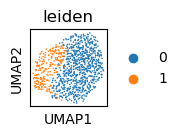

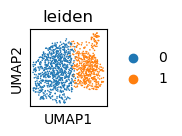

In [788]:
sig_pos = Ddense[Ddense.obs.ncorr_thresh > 0].copy()
sig_neg = Ddense[Ddense.obs.ncorr_thresh < 0].copy()
for label, d_sig, r in [('pos', sig_pos, 0.35), ('neg', sig_neg, 0.25)]:
    np.random.seed(0)
    sc.pp.neighbors(d_sig, use_rep='X')
    sc.tl.umap(d_sig)
    sc.tl.leiden(d_sig, resolution=r, key_added='leiden', seed=0)
    plt.figure(figsize=(1,1)); sc.pl.umap(d_sig, color='leiden', s=5, ax=plt.gca())
    Ddense.obs[label+'_leiden'] = d_sig.obs.leiden

# count number of patches of each type per sample
Ddense.samplem['npatches'] = Ddense.obs.sid.value_counts()
Ddense.samplem[['nneg', 'npos']] = pd.crosstab(Ddense.obs.sid, Ddense.obs.ncorr_thresh.map(
                                    lambda x: 0 if x < 0 else (1 if x > 0 else np.nan)
                                ))
Ddense.samplem.drop(columns=[c for c in Ddense.samplem.columns if c.startswith('pos') or c.startswith('neg')], inplace=True)
Ddense.samplem[[f'pos{c}' for c in Ddense.obs.pos_leiden.unique() if c == c]] = pd.crosstab(Ddense.obs.sid, Ddense.obs.pos_leiden)
Ddense.samplem[[f'neg{c}' for c in Ddense.obs.neg_leiden.unique() if c == c]] = pd.crosstab(Ddense.obs.sid, Ddense.obs.neg_leiden)
Ddense.samplem = Ddense.samplem.fillna(0)

Ddense.write(f'_results/RA/{name}-vae.h5ad')

# unused

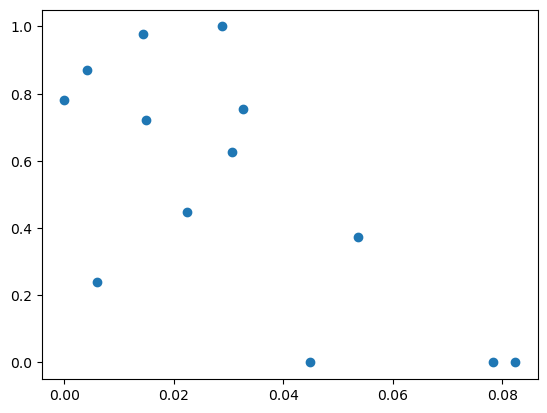

In [719]:
cond = Ddense.samplem.TB | Ddense.samplem.M | Ddense.samplem.TM
plt.scatter(Ddense.samplem[cond].npos / Ddense.samplem[cond].npatches,
            Ddense.samplem[cond].neg0 / (Ddense.samplem[cond].neg0 + Ddense.samplem[cond].neg1))

.............

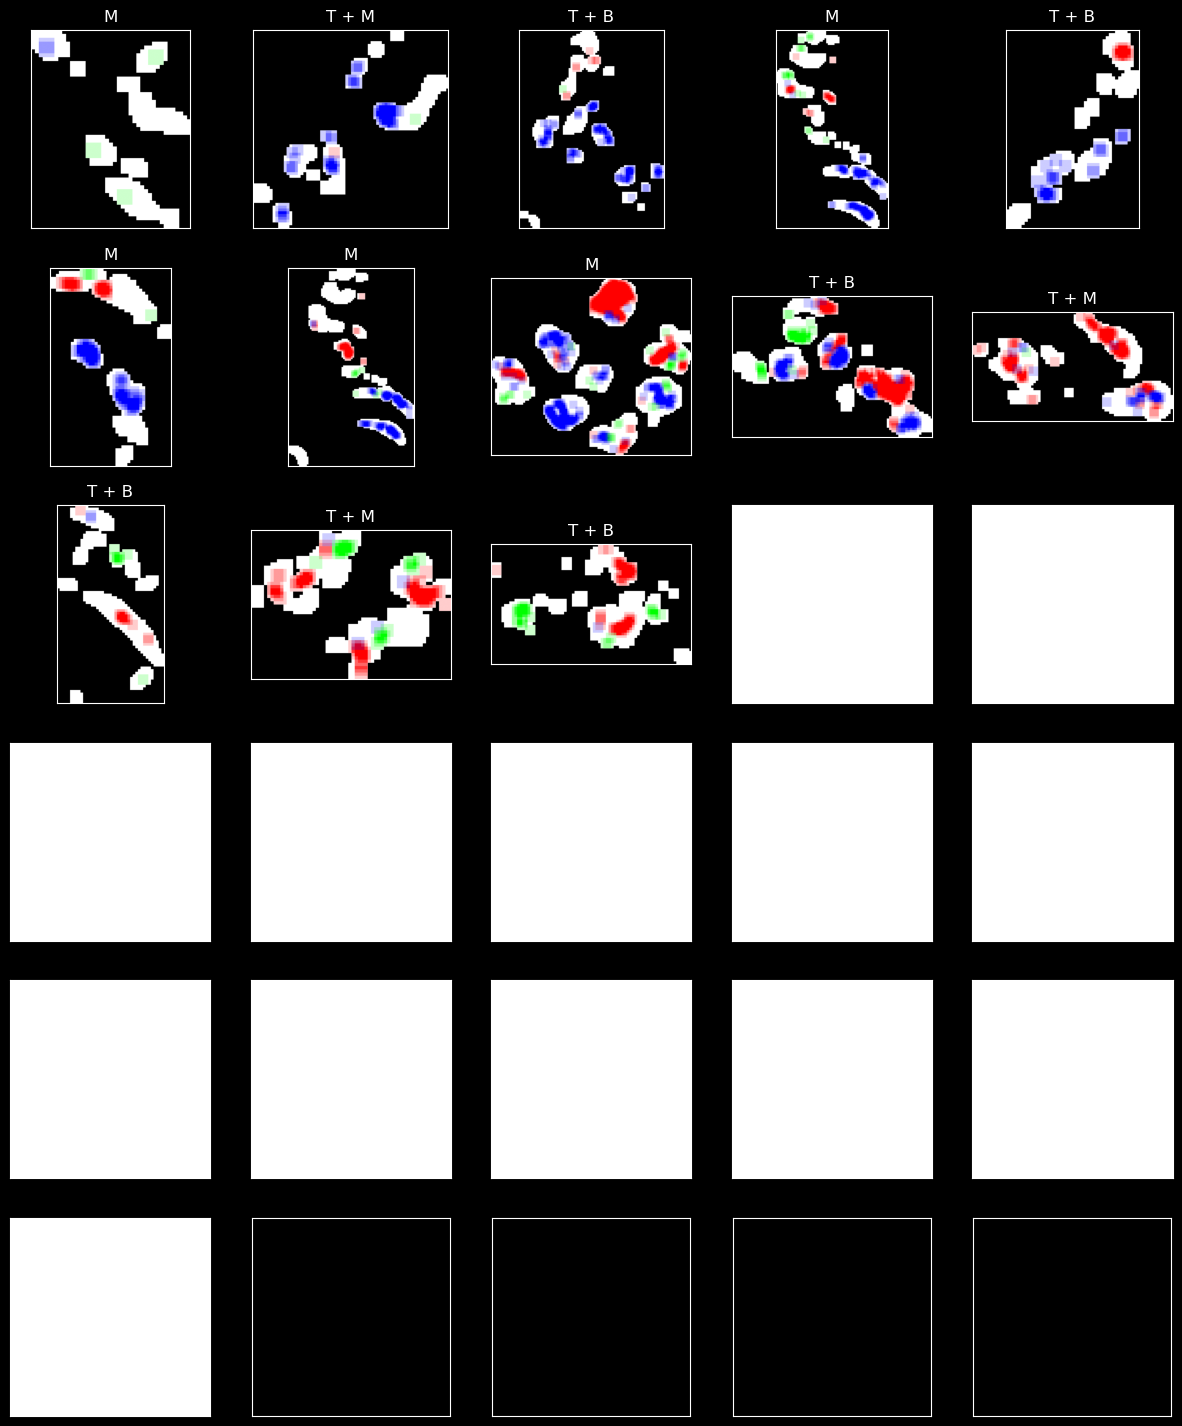

In [458]:
d = Ddense.copy()
d.obs['clust0_pos'] = d.obs['clust1_pos'] = d.obs['clust0_neg'] = d.obs['clust1_neg'] = 0
d.obs.loc[sig_neg.obs[sig_neg.obs.leiden == '0'].index, 'clust0_neg'] = 1
d.obs.loc[sig_neg.obs[sig_neg.obs.leiden == '1'].index, 'clust1_neg'] = 1
d.obs.loc[sig_pos.obs[sig_pos.obs.leiden == '0'].index, 'clust0_pos'] = 1
d.obs.loc[sig_pos.obs[sig_pos.obs.leiden == '1'].index, 'clust1_pos'] = 1
tv.spatialplot(samples,
               # d.uns['NAM_sampleXpc'].PC1,
               ct.div(ct.sum(axis=1), axis=0)['0'],
               d.obs,
               [d.obs.clust0_neg == 1, d.obs.clust1_neg == 1, d.obs.clust0_pos + d.obs.clust1_pos == 1],
               labels=Ddense.samplem.CTAP,
               rgbs=[[1,0,0],[0, 0, 1],[0,1,0]],
               skipthresh=10, filterempty=True,
               vmax=5, ncols=5, size=3, show=False)
plt.show()

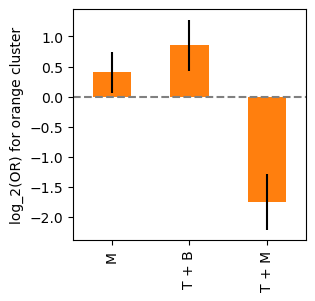

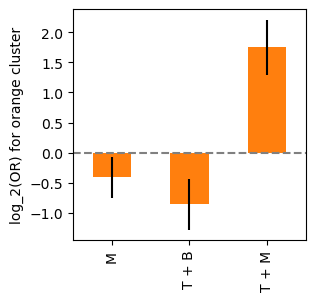

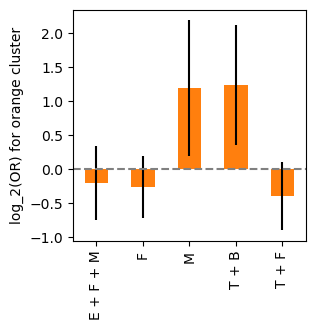

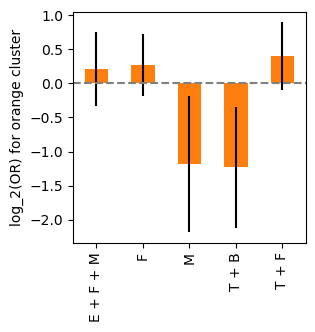

In [784]:
def get_or(totals, name):
    others = [c for c in totals.columns if c != name]
    oddsratios = pd.Series()
    ses = pd.Series()
    for ctap in totals.index:
        odds = totals.loc[ctap, name] / totals.loc[ctap, others].sum()
        ref = totals.loc[totals.index != ctap].sum(axis=0)
        ref_odds = ref[name] / ref[others].sum()
        ses.loc[ctap] = np.sqrt((1/totals.loc[ctap]).sum() + (1/ref).sum()) / np.log(2)
        oddsratios.loc[ctap] = odds / ref_odds
    return np.log2(oddsratios), ses

posclusts = [c for c in Ddense.samplem.columns if c.startswith('pos')]
negclusts = [c for c in Ddense.samplem.columns if c.startswith('neg')]
totals = Ddense.samplem[['CTAP'] + negclusts].groupby('CTAP').aggregate('sum')
totals = totals.loc[totals.sum(axis=1) > 50]
for name in negclusts:
    lors, ses = get_or(totals, name)
    plt.figure(figsize=(3,3))
    lors.plot(kind='bar', color='#ff7f0e', yerr=2*ses)
    plt.axhline(y=0, ls='--', color='gray')
    # plt.ylim(-1.4,1.4)
    plt.ylabel('log_2(OR) for orange cluster')
    plt.show()

totals = Ddense.samplem[['CTAP'] + posclusts].groupby('CTAP').aggregate('sum')
totals = totals.loc[totals.sum(axis=1) > 50]
for name in posclusts:
    lors, ses = get_or(totals, name)
    plt.figure(figsize=(3,3))
    lors.plot(kind='bar', color='#ff7f0e', yerr=2*ses)
    plt.axhline(y=0, ls='--', color='gray')
    # plt.ylim(-1.4,1.4)
    plt.ylabel('log_2(OR) for orange cluster')
    plt.show()

# Make plots

In [362]:
repname = 'normalized'
samples_markerlevel = tds.read_samples(f'../RA/BHAM-data/10u/{repname}/*.nc', fname_parser)
M = tdp.PatchCollection(
    tds.choose_patches(samples_markerlevel, patchsize, patchstride, max_frac_empty=0.8),
                        samples_markerlevel, standardize=True)
Mdense = tdp.PatchCollection(
    tds.choose_patches(samples_markerlevel, patchsize, patchstride, max_frac_empty=0.2),
                        samples_markerlevel, standardize=True)
print(len(Mdense), 'patches')
gc.collect()
markers = list(list(samples_markerlevel.values())[0].marker.values)

100%|███████████████████████████████████████████████████████████████| 27/27 [00:06<00:00,  3.99it/s]


in pytorch mode
means: [ 0.00793566 -0.01663896  0.01270739 -0.0013745   0.00480578  0.01948055
 -0.00018479]
stds: [0.71823674 0.7177866  0.7322027  0.7227469  0.7205423  0.7167216
 0.70954436]
data augmentation is off


100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  6.99it/s]


in pytorch mode
means: [ 0.11101654 -0.22448725  0.0453094  -0.01259747  0.08451502  0.19900274
  0.05392221]
stds: [0.9420133  0.84689033 0.8860208  0.90481436 0.923474   0.9975902
 0.9068022 ]
data augmentation is off
10345 patches


data augmentation is off
in numpy mode


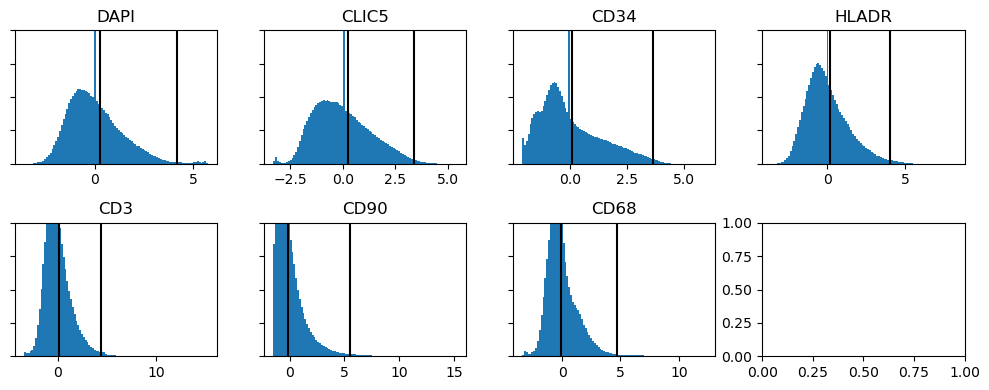

In [363]:
from scipy import stats
def make_hists(pixels, threshs=[60,99]):
    fig, axs = plt.subplots(2,4,figsize=(10,4))
    percentiles = {}
    for i, ax in zip(range(len(markers)), axs.flatten()):
        nums = pixels[:,:,:,i].flatten()
        [a, b] = np.percentile(nums[(nums-stats.mode(nums)[0])**2 > 0.01], threshs)
        percentiles[markers[i]] = [a,b]
        ax.hist(
            nums,
            bins=100)
        ax.set_title(markers[i])
        ax.set_yticklabels([])
        ax.set_ylim(0,200000)
        ax.axvline(a, color='k')
        ax.axvline(b, color='k')
    plt.tight_layout()
    plt.show()
    return percentiles

M.numpy_mode()
raw_percentiles = make_hists(M[::10][0])
raw_scalers = {
    m : tv.scaler(raw_percentiles[m][0],raw_percentiles[m][1])
    for m in markers}

fibro_cmap = [
    [markers.index(m), c, raw_scalers[m]]
    for m, c in zip(['CD34', 'CD90', 'CLIC5', 'DAPI'],
                    np.array([[1,0,0],[0.6,0.6,0.6],[1,1,0],[0,0.5,1]])*\
                    np.array([[1],[1],[1],[1]]))]

immune_cmap = [
    [markers.index(m), c, raw_scalers[m]]
    for m, c in zip(['HLADR', 'CD3', 'CD68', 'DAPI'],
                    np.array([[1,0,0],[0,1,0],[0,0,1],[0,0,0]])*\
                    np.array([[1],[0.7],[1],[1]]))]

fibrot_cmap = [
    [markers.index(m), c, raw_scalers[m]]
    for m, c in zip(['CD34', 'CD90', 'CD68', 'DAPI','CD3'],
                    np.array([[1,0,0],[0.6,0.6,0.6],[1,1,0],[0,0.5,1],[0,1,0]])*\
                    np.array([[1],[1],[1],[1],[0.7]]))]

fibroclict_cmap = [
    [markers.index(m), c, raw_scalers[m]]
    for m, c in zip(['CD34', 'CD90', 'CLIC5', 'DAPI','CD3','HLADR'],
                    np.array([[1,0,0],[0.6,0.6,0.6],[1,1,0],[0,0.5,1],[0,1,0],[0,1,1]])*\
                    np.array([[1],[1],[1],[1],[1],[1]]))]

data augmentation is off
in numpy mode


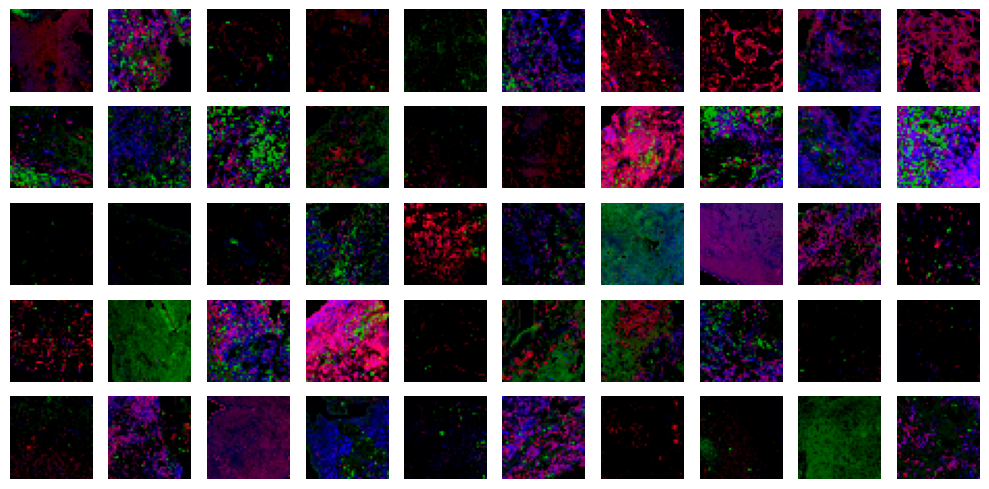

range(0, 50)

In [364]:
nexamples = 50
np.random.seed(0)
Mdense.numpy_mode()
rix = np.random.choice(len(Mdense), size=nexamples, replace=False)
tv.plot_patches_overlaychannels(
    Mdense[rix][0], immune_cmap, nx=10, ny=5)

/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


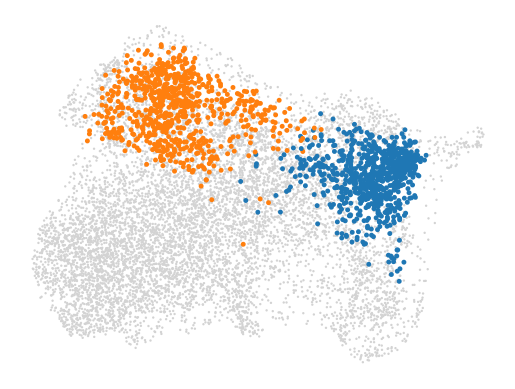

In [713]:
d_sig = sig_neg
d = Ddense
type = 'neg'

d.obs['sigclust'] = '-1'
d.obs.loc[d_sig.obs.index, 'sigclust'] = d_sig.obs.leiden
sc.pl.umap(d, ax=plt.gca(), show=False)
sc.pl.umap(d[d.obs.sigclust != '-1'], color='sigclust', legend_loc=None, ax=plt.gca(), show=False, s=50)
# plt.xlabel('UMAP1', fontsize=11); plt.ylabel('UMAP2', fontsize=11)
plt.xlabel(''); plt.ylabel('')
plt.title('')
for s in plt.gca().spines.values():
    s.set_visible(False)

outdir = f'_results/RA/associated_patches/{type}-{name}'
os.makedirs(outdir, exist_ok=True)
plt.savefig(f'{outdir}/allclusts_umap.png')
plt.show()

In [714]:
model.eval()
cluster_reps = {}
cluster_names = []
cluster_ncorrs = []
for c in d_sig.obs.leiden.unique():
    cluster_names.append(c)
    avgncorr = d_sig.obs[d_sig.obs.leiden == c].ncorr.mean()
    cluster_ncorrs.append(avgncorr)
    
    # proto = d_sig[d_sig.obs.leiden == c].X.mean(axis=0).reshape((-1,64,10,10))
    # with torch.no_grad():
        # cluster_reps[c] = model.decode(torch.tensor(proto))[0].permute(1,2,0).cpu().numpy()
cluster_info = pd.DataFrame({'cluster':cluster_names, 'ncorr':cluster_ncorrs}).sort_values('ncorr').reset_index(drop=True)
toplot = pd.concat([cluster_info.head(10), cluster_info.tail(10)]).drop_duplicates().reset_index(drop=True)

In [715]:
from PIL import Image
cmapname = 'fibro'
cmap = fibro_cmap
p = Mdense

outdir = f'_results/RA/associated_patches/{type}-{name}-{cmapname}'
os.makedirs(outdir, exist_ok=True)

reload(tv)
p.numpy_mode()
for c, ncorr in cluster_info[['cluster','ncorr']].values:
    print(c, (d_sig.obs.leiden == c).sum(), ncorr)
    d_sig.obs['inclust'] = d_sig.obs.leiden == c
    # sc.pl.umap(d_sig, color='inclust')
    ix = d_sig.obs[d_sig.obs.inclust].index.values
    d.obs['inclust'] = False
    d.obs.loc[ix, 'inclust'] = True
    ix = ix.astype(int)
    plt.figure(figsize=(8,6))
    sc.pl.umap(d, ax=plt.gca(), show=False)
    sc.pl.umap(d[d.obs.ncorr_thresh != 0], color='ncorr_thresh', cmap='seismic', vmin=-1, vmax=1, s=30, ax=plt.gca(),
               colorbar_loc=None, show=False)
    sc.pl.umap(d[d.obs.inclust], na_color='black', s=80, ax=plt.gca(), show=False, add_outline=True,
               outline_color=('white', 'white'))
    plt.xlabel('UMAP 1', fontsize=14)
    plt.ylabel('UMAP 2', fontsize=14)
    for s in plt.gca().spines.values():
        s.set_visible(False)
    plt.savefig(f'{outdir}/umap_clust{c}.png'); plt.close()
    
    tv.plot_patches_overlaychannels_som(
        p[ix][0], d[ix].X, cmap,
        seed=0, nx=6, ny=6, show=False, subsamplefactor=4
    )
    # tv.plot_patches_overlaychannels(
    #     p[ix][0], cmap,
    #     seed=0, nx=4, ny=4, show=False
    # )
    plt.gcf().patch.set_facecolor('black')
    plt.savefig(f'{outdir}/examples_clust{c}.png'); plt.close()

    # paste together the reports
    image1 = Image.open(f'{outdir}/umap_clust{c}.png')
    image2 = Image.open(f'{outdir}/examples_clust{c}.png')
    combined_width = image1.width + image2.width
    combined_height = max(image1.height, image2.height)
    combined_image = Image.new('RGB', (combined_width, combined_height), 'white')
    combined_image.paste(image1, (0, int((combined_height-image1.height)/2)))
    combined_image.paste(image2, (image1.width, 0))
    combined_image.save(f'{outdir}/combined_clust{c}.png')

data augmentation is off
in numpy mode
0 781 -0.532538051920271


/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:261: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:280: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/minisom.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


1 744 -0.5049851530438816


/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:261: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:280: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/minisom.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


.............

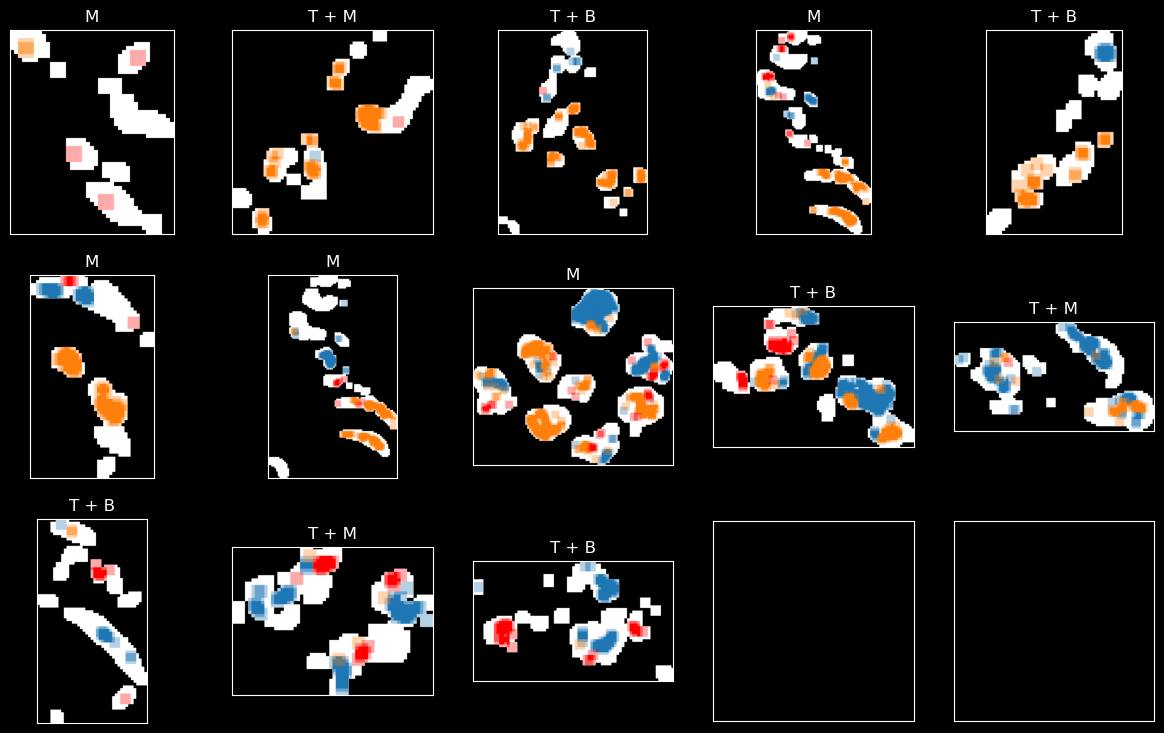

In [588]:
reload(tv)
d = Ddense.copy()
d.obs['clust0_pos'] = d.obs['clust1_pos'] = d.obs['clust0_neg'] = d.obs['clust1_neg'] = 0
d.obs.loc[sig_neg.obs[sig_neg.obs.leiden == '0'].index, 'clust0_neg'] = 1
d.obs.loc[sig_neg.obs[sig_neg.obs.leiden == '1'].index, 'clust1_neg'] = 1
d.obs.loc[sig_pos.obs[sig_pos.obs.leiden == '0'].index, 'clust0_pos'] = 1
d.obs.loc[sig_pos.obs[sig_pos.obs.leiden == '1'].index, 'clust1_pos'] = 1

tv.spatialplot({sid:s for sid, s in samples.items() if sid in frac_c0.index},
               # d.uns['NAM_sampleXpc'].PC1,
               frac_c0,
               d.obs,
               [d.obs.clust0_neg == 1, d.obs.clust1_neg == 1, d.obs.ncorr_thresh > 0],
               labels=Ddense.samplem.CTAP,
               rgbs=[[31/255,119/255,180/255],[1,0.5,.05],[1,0,0]],
               skipthresh=10, filterempty=True,
               vmax=3, ncols=5, size=3, show=False)
plt.savefig('/Users/yakir/Desktop/temp.png')
plt.show()

..........................

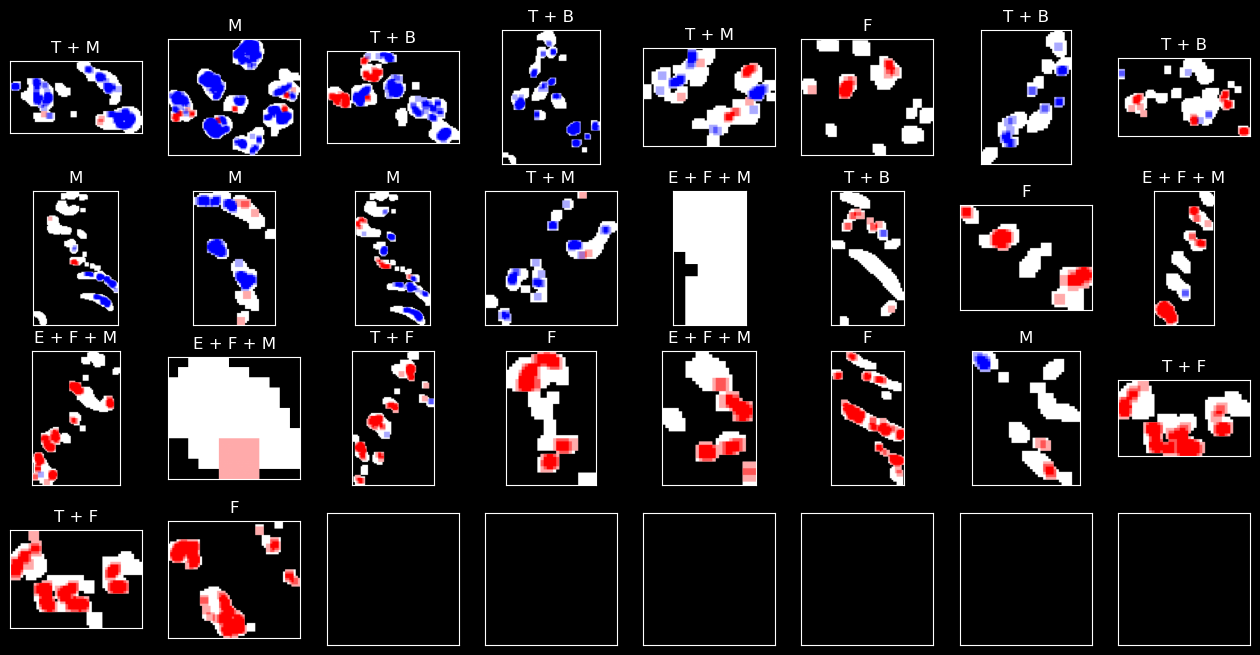

In [740]:
d = Ddense
tv.spatialplot(samples,
               d.uns['NAM_sampleXpc'].PC1,
               d.obs,
               [d.obs.ncorr_thresh > 0, d.obs.ncorr_thresh < 0],
               labels=Ddense.samplem.CTAP,
               rgbs=[[1,0,0],[0, 0, 1]],
               skipthresh=10, filterempty=True,
               vmax=3, ncols=8, size=2, show=False)
plt.savefig('/Users/yakir/Desktop/temp.png')
plt.show()